In [11]:
import os
import re
import pdb
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 800
plt.rcParams['savefig.dpi'] = 800

In [2]:
def collect_data(err_rate):
    runtimes = []
    mem_usages = []
    num_plans = []
    for domain_name in os.listdir(os.getcwd()):
        domain_dir = os.path.join(os.getcwd(), domain_name)
        if not os.path.isdir(domain_dir):
            continue
        if not os.path.exists(os.path.join(domain_dir, "err-rate-{}".format(err_rate), "diagnosis")):
            continue
        num_plan = 0
        for t in os.listdir(domain_dir):
            task_dir = os.path.join(domain_dir, t)
            if "sas_plan" not in os.listdir(task_dir):
                continue
            num_plan += 1
        if num_plan == 0:
            print(domain_name)
        num_plans.append(num_plan)
        with open(os.path.join(domain_dir, "err-rate-{}".format(err_rate), "diagnosis"), "r") as f:
            lines = [line for line in f.readlines() if line.strip()]
            mem_info = lines.pop(-1)
            mem_usage = float(mem_info.split(" ")[-1])
            time_info = lines[-1]
            time = float(time_info.split(" ")[-1])
            runtimes.append(time)
            mem_usages.append(mem_usage)
    return runtimes, mem_usages, num_plans

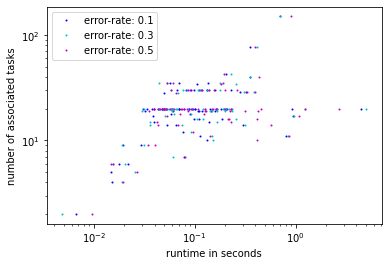

In [3]:
runtimes_all = []
colors = ["b", "c", "m"]
for i, e in enumerate([0.1, 0.3, 0.5]):
    runtimes, _, num_plans = collect_data(e)
    runtimes_all += runtimes
    plt.plot(runtimes, num_plans, ".{}".format(colors[i]), markersize=2, label="error-rate: {}".format(e))
plt.yscale("log")
plt.xscale("log")
plt.ylabel("number of associated tasks")
plt.xlabel("runtime in seconds")
plt.legend()

plt.show()

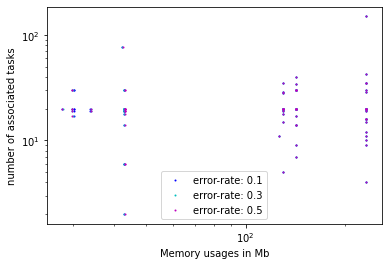

In [4]:
colors = ["b", "c", "m"]
for i, e in enumerate([0.1, 0.3, 0.5]):
    _, mem_usages, num_plans = collect_data(e)
    plt.plot(mem_usages, num_plans, ".{}".format(colors[i]), markersize=2, label="error-rate: {}".format(e))
plt.yscale("log")
plt.xscale("log")
plt.ylabel("number of associated tasks")
plt.xlabel("Memory usages in Mb")
plt.legend()

plt.show()

In [5]:
def parseFuzzyOps(line):
    #(name, operation, position, atom)
    line = line[1:-1]
    parts = line.split(":")
    name = parts[-1].strip()
    pattern = re.compile("[^\s]+\(.*\)")
    atom = pattern.search(parts[0]).group()
    body = re.sub(pattern, "", parts[0])
    body = [s for s in body.split(" ") if s.strip()]
    position = body[-1].strip()
    op = body[0].strip()
    assert(op == "Add" or op == "Remove")
    op = 1 if op == "Add" else 0
    if position == "Effs":
        atom_property = body[1].strip()
        assert(atom_property == "Atom" 
               or atom_property == "NegatedAtom")
        position = 1 if atom_property == "Atom" else 2
    elif position == "Pos-effs":
        position = 1
    elif position == "Neg-effs":
        position = 2
    elif position == "Prec":
        position = 0
    else:
        assert(False)
    return (name, op, position, atom)

In [6]:
def parseRepairOps(line):
    line = line[1:-1]
    line = line.split("|")[0]
    parts = line.split(":")[1:]
    name = parts[-1].strip()
    pattern = re.compile("[^\s]+\(.*\)")
    atom = pattern.search(parts[0]).group()
    body = re.sub(pattern, "", parts[0])
    body = [s for s in body.split(" ") if s.strip()]
    position = body[-1].strip()
    op = body[0].strip()
    assert(op == "Add" or op == "Remove")
    op = 1 if op == "Add" else 0
    assert(position == "Precondition" or position == "Effects")
    if position == "Precondition":
        position = 0
    else:
        atom_property = body[1].strip()
        assert(atom_property == "Atom" 
               or atom_property == "NegatedAtom")
        position = 1 if atom_property == "Atom" else 2
    return (name, op, position, atom)

In [9]:
def statistical_data(err_rate):
    num_total = 0
    num_correct = 0
    for domain_name in os.listdir(os.getcwd()):
        domain_dir = os.path.join(os.getcwd(), domain_name)
        if not os.path.isdir(domain_dir):
            continue
        diagnosis_file = os.path.join(domain_dir, 
                                      "err-rate-{}".format(err_rate), 
                                      "diagnosis")
        fuzz_file = os.path.join(domain_dir,
                                 "err-rate-{}".format(err_rate),
                                 "fuzz_ops.txt")
        if not os.path.exists(diagnosis_file):
            continue
        with open(diagnosis_file, "r") as f:
            lines = f.readlines()
            lines = lines[:-2]
            repairs = [parseRepairOps(line.strip("\n")) for line in lines]
        with open(fuzz_file, "r") as f:
            lines = f.readlines()
            fuzz_ops = [parseFuzzyOps(line.strip("\n")) for line in lines]
        num_total += len(repairs)
        for repair in repairs:
            for op in fuzz_ops:
                if repair[0] == op[0] \
                        and repair[1] + op[1] == 1 \
                        and repair[2] == op[2] \
                        and repair[3] == op[3]:
                    num_correct += 1
                    break
    return (num_correct, num_total)

In [12]:
total_correct = 0
total_instances = 0
for err_rate in [0.1, 0.3, 0.5]:
    num_correct, num_instances = statistical_data(err_rate)
    total_correct += num_correct
    total_instances += num_instances
total_correct / total_instances

0.7802547770700637